### Installing important libraries

In [74]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import random
import seaborn as sns
import mplfinance as mpf

### Downloading FTSE 250 data

In [75]:
# Fetching historical data for FTSE 250
ftse_250_data = yf.download("^FTMC", start="2015-01-01", end="2024-08-01")

# Modifying the columns to 1 decimal:
ftse_250_data = ftse_250_data.round(decimals=1)

print(ftse_250_data)

[*********************100%%**********************]  1 of 1 completed

               Open     High      Low    Close  Adj Close     Volume
Date                                                                
2015-01-02  16085.4  16103.1  15977.7  16052.0    16052.0  126821600
2015-01-05  16052.0  16141.4  15910.5  15921.7    15921.7  211207200
2015-01-06  15921.7  15980.2  15778.4  15778.7    15778.7  250197700
2015-01-07  15778.7  15924.2  15778.7  15851.7    15851.7  250241800
2015-01-08  15851.7  16086.5  15851.7  16085.5    16085.5  259066600
...             ...      ...      ...      ...        ...        ...
2024-07-25  20950.8  20951.5  20699.1  20884.4    20884.4  252681300
2024-07-26  20884.4  21360.5  20856.5  21356.3    21356.3  264561800
2024-07-29  21356.3  21490.3  21221.1  21252.1    21252.1  239958100
2024-07-30  21252.1  21508.8  21195.4  21432.5    21432.5  305575900
2024-07-31  21432.5  21649.5  21430.1  21600.7    21600.7  309322400

[2420 rows x 6 columns]


### Data Pre-processing

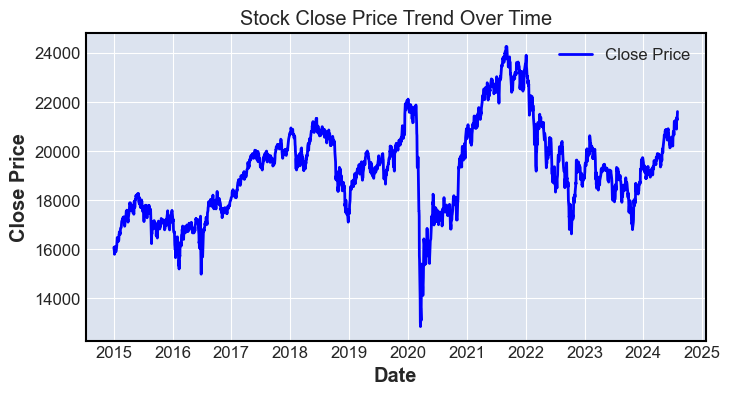

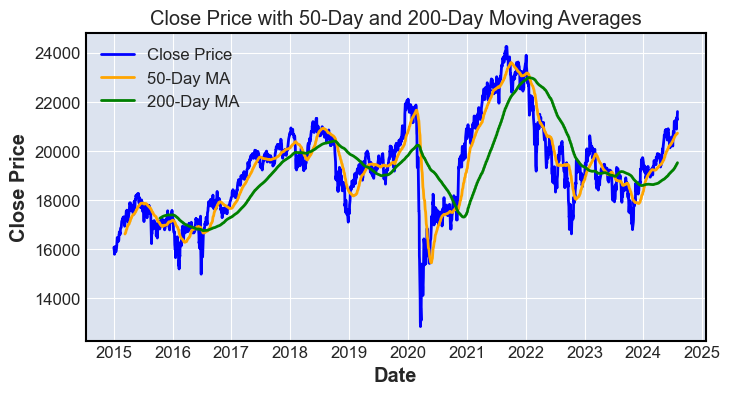

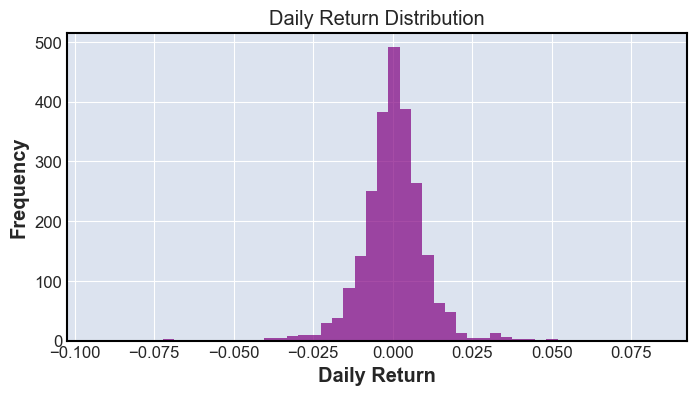

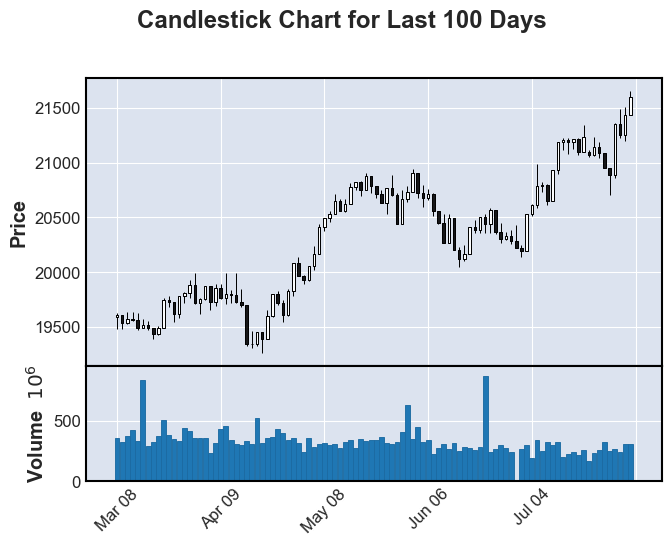

In [95]:


# creating a dataframe df for preprocessing
df = ftse_250_data.reset_index().copy()

# Convert 'Date' to datetime for proper time-series handling
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 1. Summary Statistics
summary_stats = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].describe()


# 2. Plot the Closing Price Trend
plt.figure(figsize=(8,4))
plt.plot(df.index, df['Close'], color='blue', label='Close Price')
plt.title('Stock Close Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# 3. Moving Averages
df['50_MA'] = df['Close'].rolling(window=50).mean()
df['200_MA'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(8,4))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['50_MA'], label='50-Day MA', color='orange')
plt.plot(df.index, df['200_MA'], label='200-Day MA', color='green')
plt.title('Close Price with 50-Day and 200-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# 4. Daily Returns
df['Daily_Return'] = df['Close'].pct_change()

plt.figure(figsize=(8,4))
plt.hist(df['Daily_Return'].dropna(), bins=50, color='purple', alpha=0.7)
plt.title('Daily Return Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 5. Candlestick Chart
# Plot the last 100 days for better visibility
mpf.plot(df[-100:], type='candle', volume=True, title='Candlestick Chart for Last 100 Days')

In [96]:
ftse_250_data.describe().round(decimals=1)

,Open,High,Low,Close,Adj Close,Volume
count,2420.0,2420.0,2420.0,2420.0,2420.0,2.420000e+03
mean,19225.8,19333.3,19120.5,19228.1,19228.1,3.101067e+08
std,1852.5,1843.7,1864.1,1852.1,1852.1,1.160528e+08
min,12829.7,13035.1,12373.5,12829.7,12829.7,0.000000e+00
25%,17753.5,17841.7,17638.4,17754.9,17754.9,2.492754e+08
50%,19263.8,19352.8,19165.8,19264.4,19264.4,2.953385e+08
75%,20304.6,20419.8,20222.8,20307.0,20307.0,3.484252e+08
max,24250.8,24353.9,24176.3,24250.8,24250.8,1.231878e+09


### Labelling of data

In [97]:
 # Labelling
def create_dataset(data, window=15):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data.iloc[i:i+window].values)
        y.append(data.iloc[i+window].values)
    return np.array(X), np.array(y)

### Splitting and scaling of the data

In [98]:
# Data Splitting: Train-Test and validation Split
train_size = int(len(ftse_250_data) * 0.7)
val_size = int(len(ftse_250_data) * 0.15)

train_data = ftse_250_data[:train_size]
val_data = ftse_250_data[train_size :train_size+val_size]
test_data = ftse_250_data[train_size+val_size:]

def rolling_min_max_scaling(train_data, val_data, test_data, window=15):
    scaler = MinMaxScaler()
    scaled_train_data = train_data.copy()
    scaled_val_data = val_data.copy()
    scaled_test_data = test_data.copy()

    # Scale training data
    for i in range(len(train_data)):
        start_idx = max(0, i - window + 1)
        end_idx = i + 1
        window_data = train_data[start_idx:end_idx]
        scaled_window = scaler.fit_transform(window_data)
        scaled_train_data.iloc[i] = scaled_window[-1]

    # Scale validation data
    for i in range(len(val_data)):
        start_idx = max(0, len(train_data) - window + 1)
        end_idx = len(train_data) + i + 1
        window_data = np.vstack((train_data[start_idx:], val_data.iloc[:i+1]))
        scaled_window = scaler.fit_transform(window_data)
        scaled_val_data.iloc[i] = scaled_window[-1]

    # Scale test data
    for i in range(len(test_data)):
        start_idx = max(0, len(train_data) + len(val_data) - window + 1)
        end_idx = len(train_data) + len(val_data) + i + 1
        window_data = np.vstack((train_data[-window:], val_data, test_data.iloc[:i+1]))
        scaled_window = scaler.fit_transform(window_data)
        scaled_test_data.iloc[i] = scaled_window[-1]

    return scaled_train_data, scaled_val_data, scaled_test_data, scaler


# Apply the scaling
scaled_train_data, scaled_val_data, scaled_test_data, scaler = rolling_min_max_scaling(train_data[['Close']], val_data[['Close']],test_data[['Close']])

### Model building

In [99]:
# Set seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

### CNN Model

In [100]:
# Creating datasets
window_size = 15
X_train_cnn, y_train_cnn = create_dataset(scaled_train_data[['Close']], window=window_size)
X_val_scaled, y_val = create_dataset(scaled_val_data[['Close']], window=window_size)
X_test_cnn, y_test_cnn = create_dataset(scaled_test_data[['Close']], window=window_size)

# CNN Model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mean_squared_error')
history_cnn = cnn_model.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_scaled, y_val),epochs=5, batch_size=16, verbose=0)

# Predict with CNN
cnn_predictions_scaled = cnn_model.predict(X_test_cnn)

# Reverse Scaling for CNN
cnn_predictions = scaler.inverse_transform(cnn_predictions_scaled).flatten()

C:\Users\bhart\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


### LSTM Model

In [101]:
# Preparing data for LSTM
X_train_lstm, y_train_lstm = create_dataset(scaled_train_data[['Close']], window=window_size)
X_val_scaled, y_val = create_dataset(scaled_val_data[['Close']], window=window_size)
X_test_lstm, y_test_lstm = create_dataset(scaled_test_data[['Close']], window=window_size)

# Reshape input to be 3D for LSTM [samples, time steps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
history_lstm = lstm_model.fit(X_train_lstm, y_train_lstm, validation_data=(X_val_scaled, y_val),epochs=5, batch_size=16, verbose=0)

# Predict with LSTM
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)

# Reverse Scaling for LSTM
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled).flatten()

C:\Users\bhart\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


### ANN Model

In [103]:
X_train_ann, y_train_ann = create_dataset(scaled_train_data[['Close']], window=window_size)
X_val_ann, y_val = create_dataset(scaled_val_data[['Close']], window=window_size)
X_test_ann, y_test_ann = create_dataset(scaled_test_data[['Close']], window=window_size)

ann_model = Sequential([
    Dense(100, activation='relu', input_shape=(window_size,)),
    Dense(1)
])
ann_model.compile(optimizer='adam', loss='mean_squared_error')
history_ann = ann_model.fit(X_train_ann, y_train_ann, validation_data=(X_val_ann, y_val), epochs=5, batch_size=16, verbose=0)

# Predict with ANN
ann_predictions_scaled = ann_model.predict(X_test_ann)

# Reverse Scaling for ANN
ann_predictions = scaler.inverse_transform(ann_predictions_scaled).flatten()

C:\Users\bhart\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


### Plot training and validation loss values

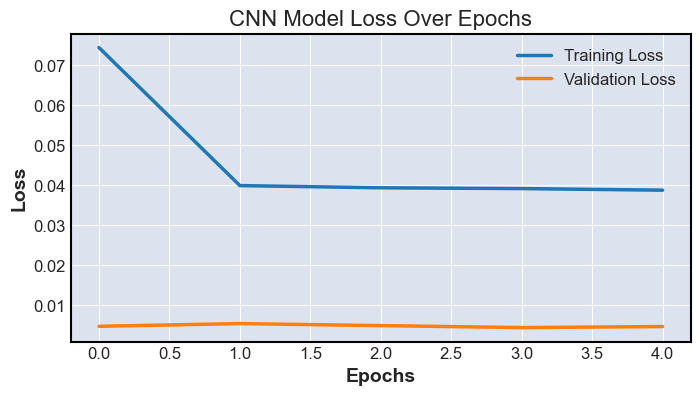

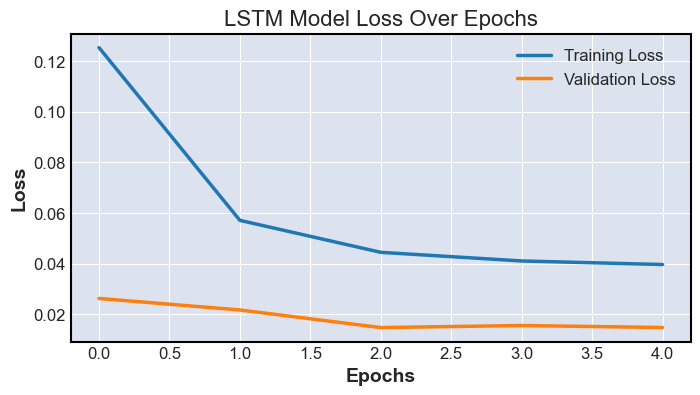

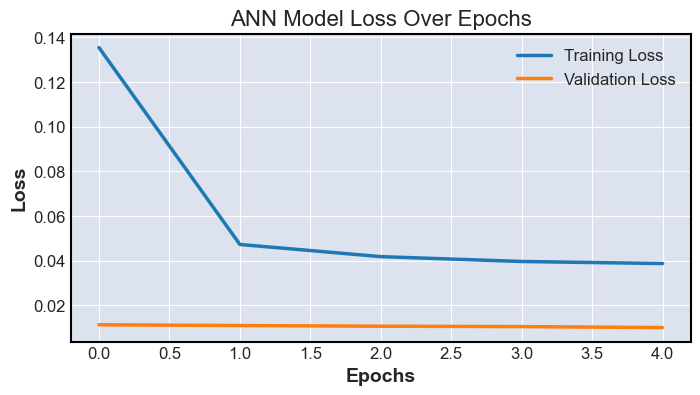

In [110]:
# CNN PLot
plt.figure(figsize=(8, 4))
plt.plot(history_cnn.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('CNN Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

#LSTM Plot
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('LSTM Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

# ANN Plot
plt.figure(figsize=(8, 4))
plt.plot(history_ann.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_ann.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('ANN Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

### Model evaluation

CNN - MAE: 172.50, MSE: 49339.93, RMSE: 222.13
LSTM - MAE: 682.10, MSE: 534841.51, RMSE: 731.33
ANN - MAE: 508.38, MSE: 323605.17, RMSE: 568.86


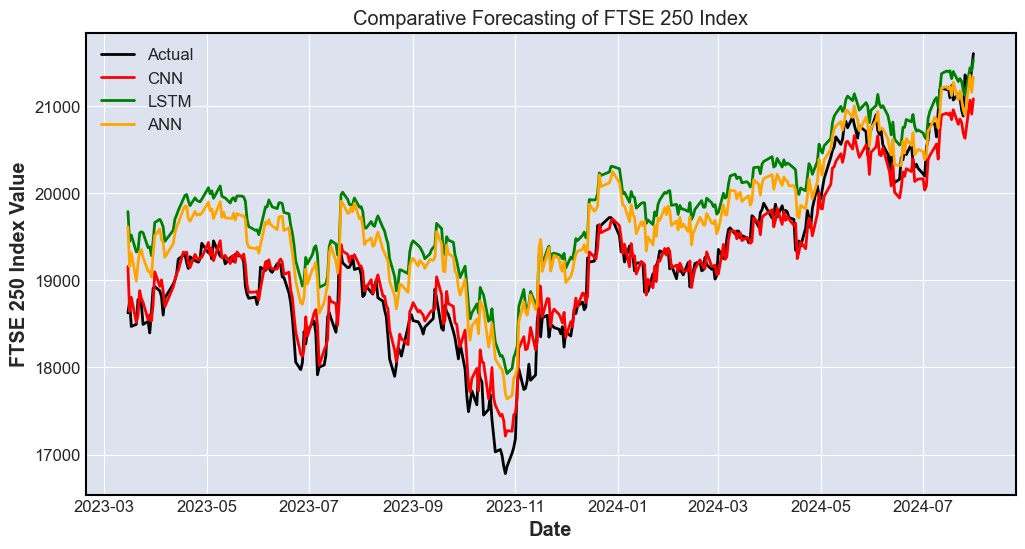

In [113]:
def evaluate_model(true_values, predictions, model_name):
    # Ensure predictions and true values have the same length for comparison
    min_length = min(len(true_values), len(predictions))
    true_values = true_values[:min_length]
    predictions = predictions[:min_length]
    mae = mean_absolute_error(true_values, predictions) # Now compares arrays of the same length
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

# Evaluate models on test data, ensuring consistent lengths
evaluate_model(test_data['Close'][window_size:], cnn_predictions, "CNN")
evaluate_model(test_data['Close'][window_size:], lstm_predictions, "LSTM")
evaluate_model(test_data['Close'][window_size:], ann_predictions, "ANN")

# Comparative Analysis
plt.figure(figsize=(12, 6))

# Plotting the pricted and actual test values for the 3 algorithms
plt.plot(test_data.index[window_size:], test_data['Close'][window_size:], label='Actual', color='black')
plt.plot(test_data.index[window_size:], cnn_predictions, label='CNN', color='red')
plt.plot(test_data.index[window_size:], lstm_predictions, label='LSTM', color='green')
plt.plot(test_data.index[window_size:], ann_predictions, label='ANN', color='orange')

plt.title('Comparative Forecasting of FTSE 250 Index')
plt.xlabel('Date')
plt.ylabel('FTSE 250 Index Value')
plt.legend()
plt.show()

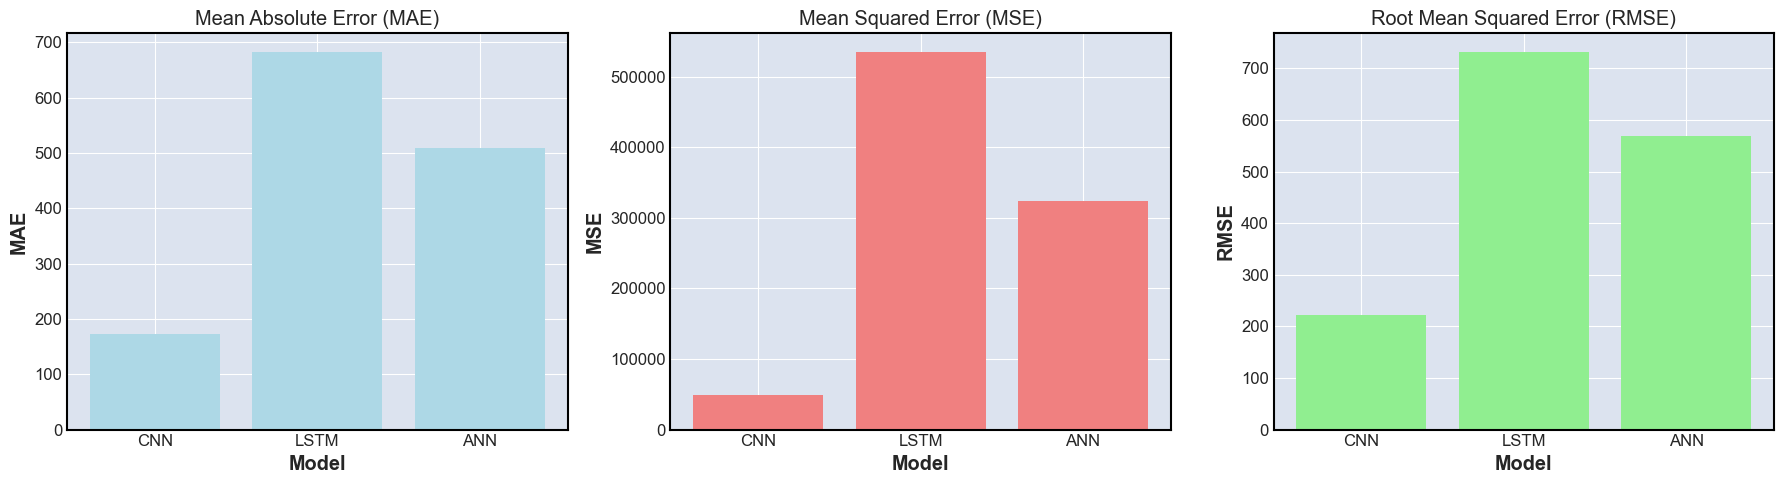

In [107]:
def evaluate_model(true_values, predictions):
    min_length = min(len(true_values), len(predictions))
    true_values = true_values[:min_length]
    predictions = predictions[:min_length]
    
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

# Assuming you have the true values and predictions for each model
true_values = test_data['Close'][window_size:]
models_predictions = {
    'CNN': cnn_predictions,
    'LSTM': lstm_predictions,
    'ANN': ann_predictions
}

# Compute metrics for each model
metrics = {model: evaluate_model(true_values, preds) for model, preds in models_predictions.items()}

# Prepare data for plotting
models = list(metrics.keys())
mae_values = [metrics[model][0] for model in models]
mse_values = [metrics[model][1] for model in models]
rmse_values = [metrics[model][2] for model in models]

# Plot MAE, MSE, and RMSE
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MAE
axs[0].bar(models, mae_values, color='lightblue')
axs[0].set_title('Mean Absolute Error (MAE)')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('MAE')

# MSE
axs[1].bar(models, mse_values, color='lightcoral')
axs[1].set_title('Mean Squared Error (MSE)')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('MSE')

# RMSE
axs[2].bar(models, rmse_values, color='lightgreen')
axs[2].set_title('Root Mean Squared Error (RMSE)')
axs[2].set_xlabel('Model')
axs[2].set_ylabel('RMSE')

plt.tight_layout()
plt.show()


### Predicting 15th and 30th day from today using predicted data

CNN - MAE: 1559.28, MSE: 2525414.49, RMSE: 1589.16
LSTM - MAE: 843.49, MSE: 783085.37, RMSE: 884.92
ANN - MAE: 1037.30, MSE: 1169716.98, RMSE: 1081.53

Comparison of 15th and 30th Day Predictions with Actual Values:
15th Day (2024-06-18 00:00:00): Actual: 20409.90, CNN: 18718.10, LSTM: 19447.15, ANN: 19296.45
30th Day (2024-07-02 00:00:00): Actual: 20194.50, CNN: 19322.53, LSTM: 19932.73, ANN: 19814.01


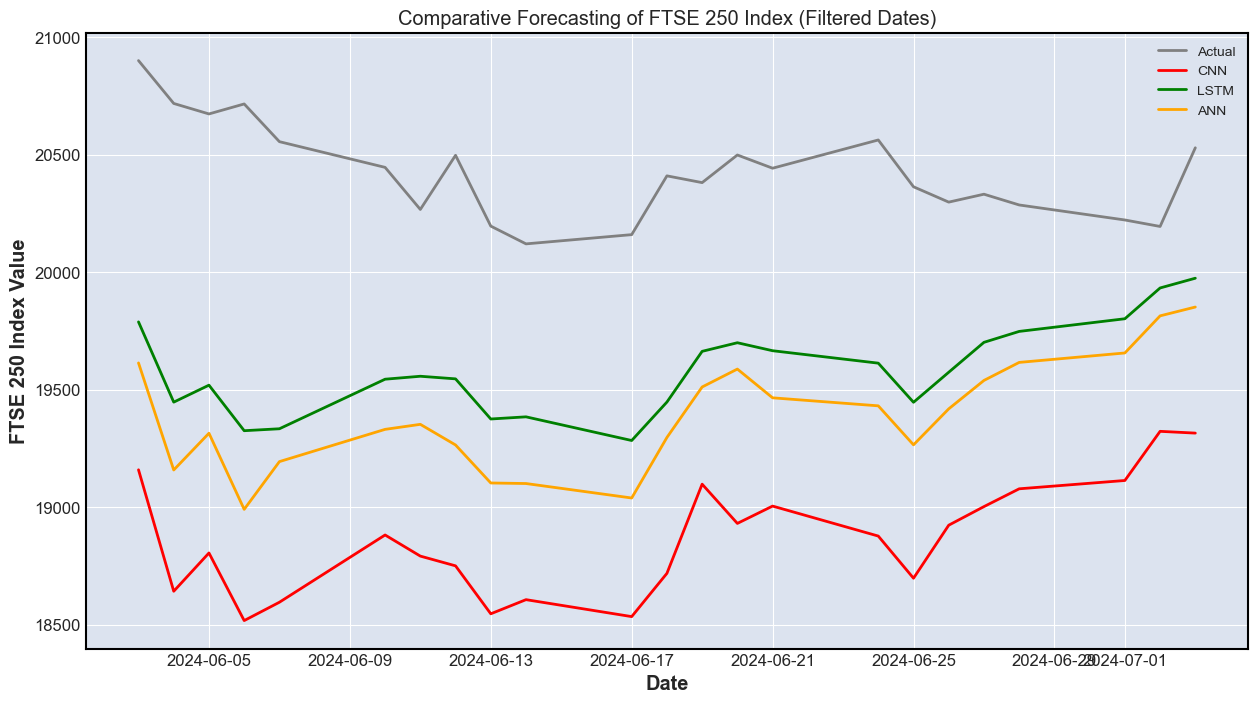

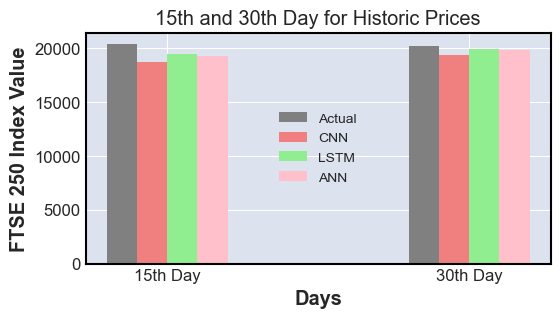

In [111]:
def evaluate_model(true_values, predictions, model_name):
    min_length = min(len(true_values), len(predictions))
    true_values = true_values[:min_length]
    predictions = predictions[:min_length]

    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

# Specifing the date range for plotting test data predictions
start_date = '2024-06-01'
end_date = '2024-07-03'

# Filter the test data for the specified date range
filtered_test_data = test_data.loc[(test_data.index >= start_date) & (test_data.index <= end_date)]

# Get the corresponding index positions from the filtered test data
filtered_indices = filtered_test_data.index.get_indexer(filtered_test_data.index)

# Filter the predictions using these index positions
filtered_cnn_predictions = np.array(cnn_predictions)[filtered_indices]
filtered_lstm_predictions = np.array(lstm_predictions)[filtered_indices]
filtered_ann_predictions = np.array(ann_predictions)[filtered_indices]

# Evaluate models on the filtered test data
evaluate_model(filtered_test_data['Close'], filtered_cnn_predictions, "CNN")
evaluate_model(filtered_test_data['Close'], filtered_lstm_predictions, "LSTM")
evaluate_model(filtered_test_data['Close'], filtered_ann_predictions, "ANN")

# Extracting the 15th and 30th day's actual and predicted values. This is extracted between June and July which is a part of my test dataset
day_15 = 11  # Index for 15th day (0-based index, so 11 corresponds to 15th day)
day_30 = 21  # Index for 30th day

# Get actual values and predictions for the 15th and 30th day
actual_15 = filtered_test_data['Close'].iloc[day_15]
cnn_15 = filtered_cnn_predictions[day_15]
lstm_15 = filtered_lstm_predictions[day_15]
ann_15 = filtered_ann_predictions[day_15]

actual_30 = filtered_test_data['Close'].iloc[day_30]
cnn_30 = filtered_cnn_predictions[day_30]
lstm_30 = filtered_lstm_predictions[day_30]
ann_30 = filtered_ann_predictions[day_30]

# Print comparison for the 15th and 30th days
print("\nComparison of 15th and 30th Day Predictions with Actual Values:")
print(f"15th Day ({filtered_test_data.index[day_15]}): Actual: {actual_15:.2f}, CNN: {cnn_15:.2f}, LSTM: {lstm_15:.2f}, ANN: {ann_15:.2f}")
print(f"30th Day ({filtered_test_data.index[day_30]}): Actual: {actual_30:.2f}, CNN: {cnn_30:.2f}, LSTM: {lstm_30:.2f}, ANN: {ann_30:.2f}")

# Plotting the actual and predicted values for the entire month
plt.figure(figsize=(15, 8))

# Plot the actual values
plt.plot(filtered_test_data.index, filtered_test_data['Close'], label='Actual', color='grey')

# Plot the CNN, LSTM, and ANN predictions
plt.plot(filtered_test_data.index, filtered_cnn_predictions, label='CNN', color='red')
plt.plot(filtered_test_data.index, filtered_lstm_predictions, label='LSTM', color='green')
plt.plot(filtered_test_data.index, filtered_ann_predictions, label='ANN', color='orange')

plt.title('Comparative Forecasting of FTSE 250 Index (Filtered Dates)')
plt.xlabel('Date')
plt.ylabel('FTSE 250 Index Value')

# Adjust legend location to the top right and make it smaller
plt.legend(loc='upper right', fontsize='small')

# Display the plot
plt.show()

# Pictorial representation for the 15th and 30th day comparison
fig, ax = plt.subplots(figsize=(6, 3))

# Bar labels and values for the 15th and 30th days
labels = ['15th Day', '30th Day']
actual_values = [actual_15, actual_30]
cnn_values = [cnn_15, cnn_30]
lstm_values = [lstm_15, lstm_30]
ann_values = [ann_15, ann_30]

# X positions for the bars
x = np.arange(len(labels))

# Bar width
bar_width = 0.1

# Plot bars for actual and model predictions with light colors
ax.bar(x - bar_width, actual_values, bar_width, label='Actual', color='grey')
ax.bar(x, cnn_values, bar_width, label='CNN', color='lightcoral')
ax.bar(x + bar_width, lstm_values, bar_width, label='LSTM', color='lightgreen')
ax.bar(x + 2 * bar_width, ann_values, bar_width, label='ANN', color='pink')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Days')
ax.set_ylabel('FTSE 250 Index Value')
ax.set_title('15th and 30th Day for Historic Prices')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(labels)

# Adjust legend location to the top right and make it smaller
ax.legend(loc='center', fontsize='small')

# Display the bar plot
plt.show()
